<a href="https://colab.research.google.com/github/Shekhawat34/Real-TIme-Stock-Market-Prediction/blob/main/yahoo_stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed


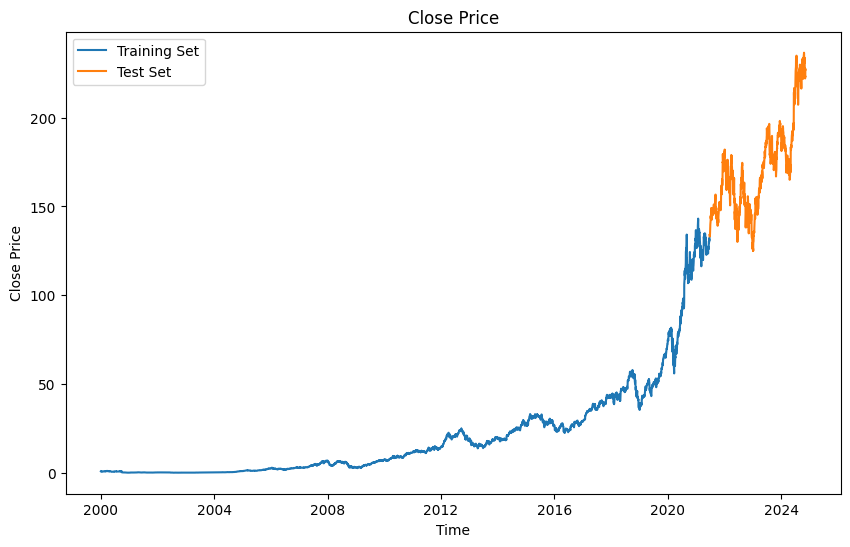

<ipython-input-8-9fd9f801a3a6>:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_set['diff_1'] = training_set['close'].diff(1)


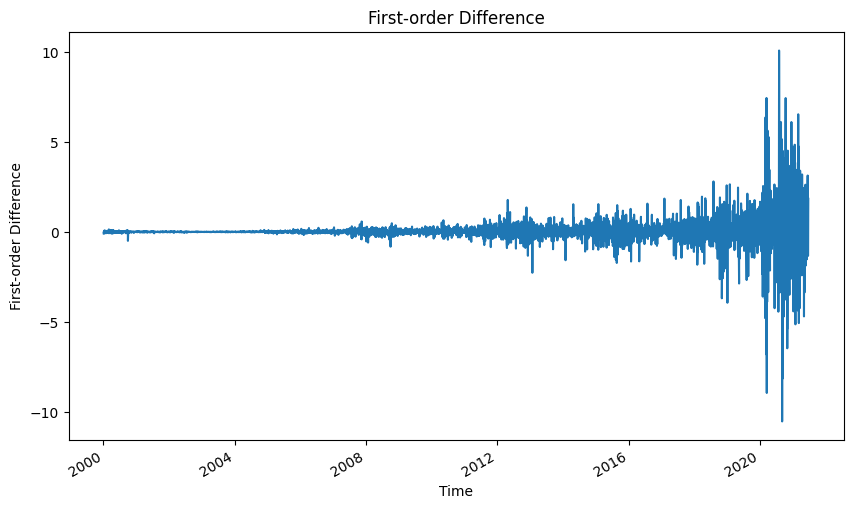

<ipython-input-8-9fd9f801a3a6>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_set['diff_2'] = training_set['diff_1'].diff(1)


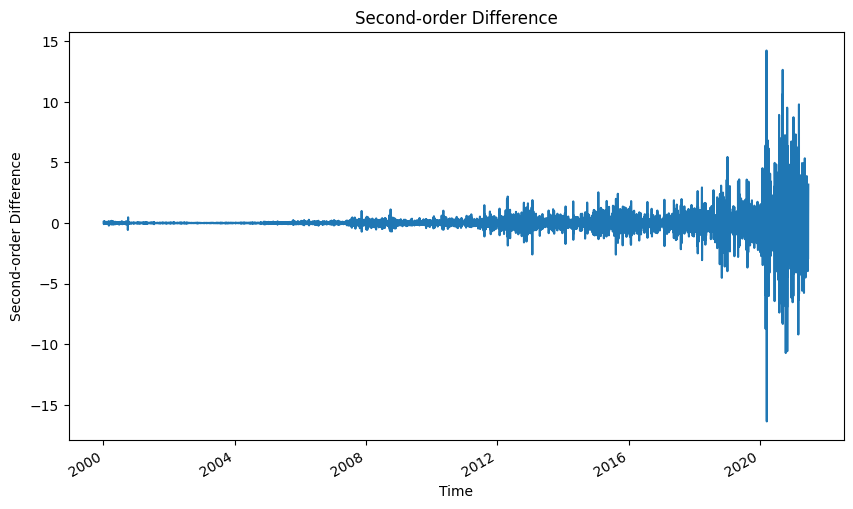

   lb_stat     lb_pvalue
2  75.0677  5.003294e-17


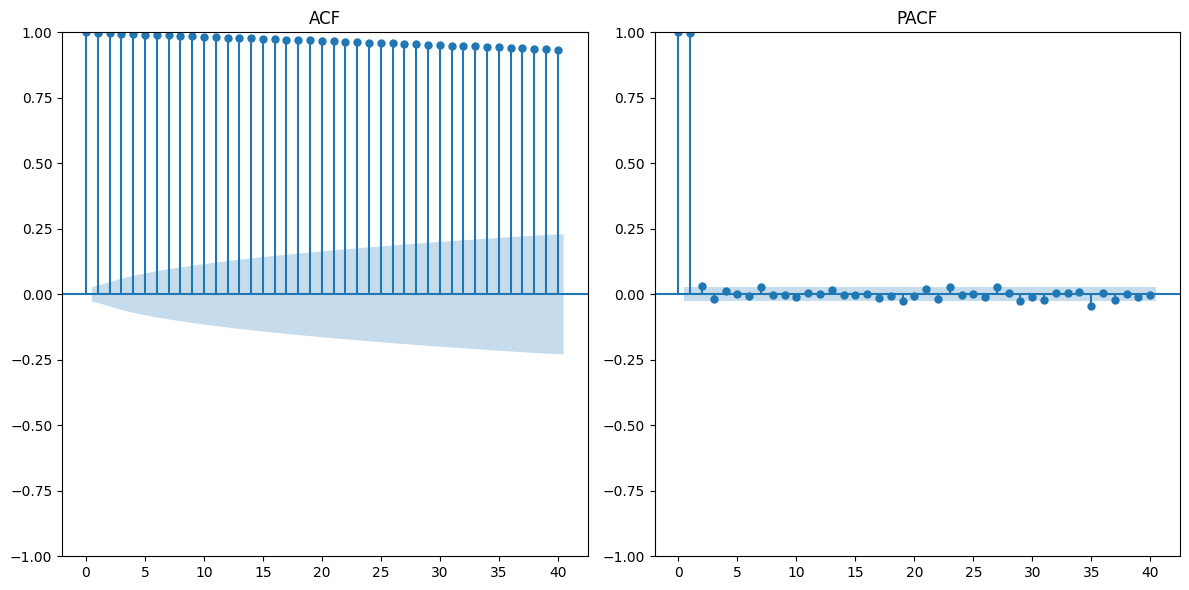

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


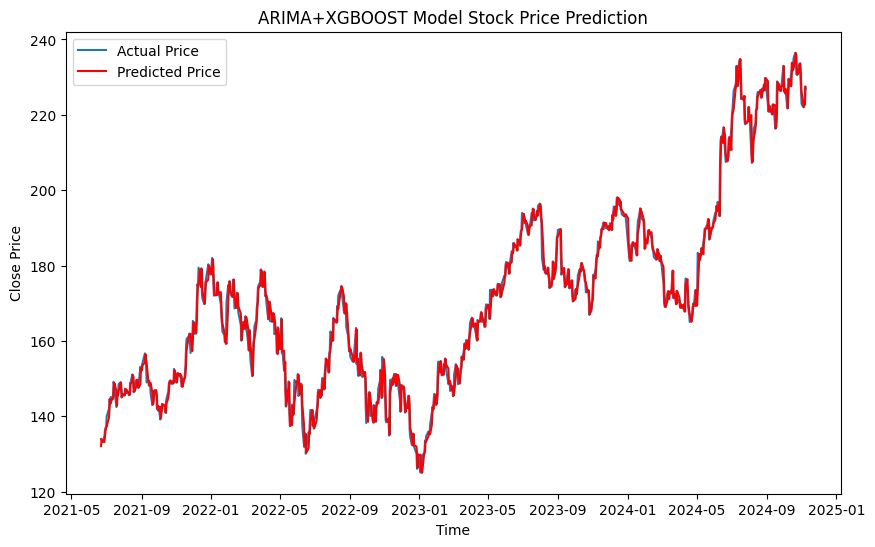

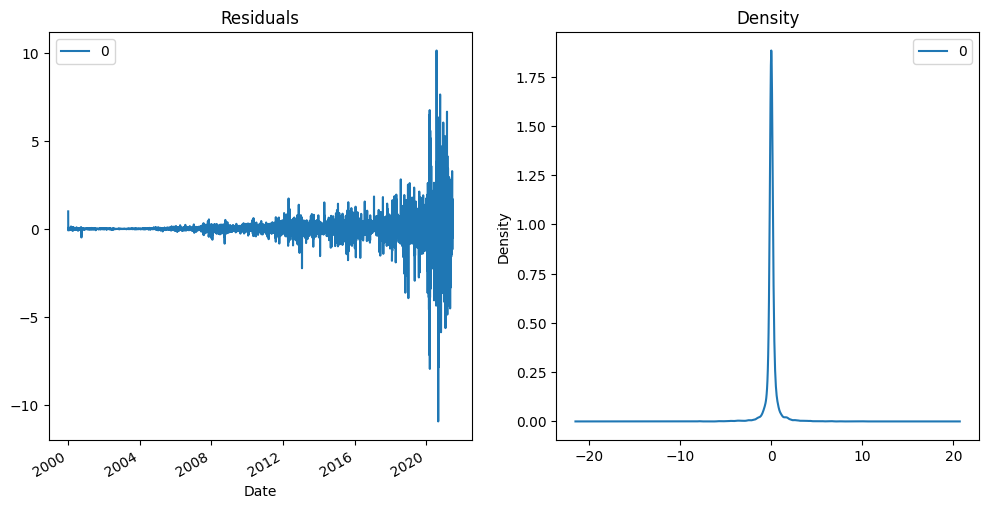

MSE:  7.872580160057091
RMSE:  2.805811854001813
MAE:  2.0896762054172897
R2:  0.9881602612882122
ADF Statistic: 3.4783930578193254
p-value: 1.0
Critical Values:
   1%, -3.4315687834958633
   5%, -2.8620785786396556
   10%, -2.5670566846658236


In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn import metrics


def plot_acf_pacf(series, acf_lags=40):
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plot_acf(series, lags=acf_lags, ax=plt.gca())
    plt.title('ACF')
    plt.subplot(122)
    plot_pacf(series, lags=acf_lags, ax=plt.gca())
    plt.title('PACF')
    plt.tight_layout()
    plt.show()

# Function for evaluation metrics
def evaluation_metric(true_values, predicted_values):

    mae = metrics.mean_absolute_error(true_values, predicted_values)
    mse = metrics.mean_squared_error(true_values, predicted_values)
    rmse = np.sqrt(mse)
    r_2 = metrics.r2_score(true_values, predicted_values)


    print('MSE: ',mse)
    print('RMSE: ',rmse)
    print('MAE: ',mae)
    print('R2: ',r_2)

# Function to perform ADF test for stationarity
from statsmodels.tsa.stattools import adfuller
def perform_adf_test(series):
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}, {value}')

# Fetching data from Yahoo Finance
ticker = 'AAPL'  # Example ticker symbol for Apple; replace with desired stock
data = yf.download(ticker, start='2000-01-01', end='2024-11-10')

# Selecting the close prices and preparing the training and test sets
data = data[['Close']].rename(columns={'Close': 'close'})
training_set = data.loc[:'2021-06-21']
test_set = data.loc['2021-06-22':]

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(training_set['close'], label='Training Set')
plt.plot(test_set['close'], label='Test Set')
plt.title('Close Price')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# First-order difference
training_set['diff_1'] = training_set['close'].diff(1)
plt.figure(figsize=(10, 6))
training_set['diff_1'].plot()
plt.title('First-order Difference')
plt.xlabel('Time')
plt.ylabel('First-order Difference')
plt.show()

# Second-order difference
training_set['diff_2'] = training_set['diff_1'].diff(1)
plt.figure(figsize=(10, 6))
training_set['diff_2'].plot()
plt.title('Second-order Difference')
plt.xlabel('Time')
plt.ylabel('Second-order Difference')
plt.show()

diff_1_series = training_set['diff_1'].dropna()
print(acorr_ljungbox(diff_1_series, lags=[2], return_df=True))


plot_acf_pacf(training_set['close'], acf_lags=40)


model = ARIMA(training_set['close'], order=(2, 1, 0)).fit()

history = training_set['close'].values.tolist()
predictions = []
for t in range(len(test_set)):
    model_t = ARIMA(history, order=(2, 1, 0))
    model_fit = model_t.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    obs = test_set['close'].iloc[t]
    history.append(obs)  # Ensure o


plt.figure(figsize=(10, 6))
plt.plot(test_set['close'], label='Actual Price')
plt.plot(test_set.index, predictions, label='Predicted Price', color='red')
plt.title('ARIMA+XGBOOST Model Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

residuals = pd.DataFrame(model.resid)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()


evaluation_metric(test_set['close'], predictions)

perform_adf_test(training_set['close'])
